In [1]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.slice_dataset_2D import MRISegmentation2DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.base_models.kiUNets import KiUNet, KiUNetWithTranspose, KiUNet3D
from trustworthai.models.base_models.UNet import UNet
from trustworthai.models.base_models.torchUNet import UNet as TUNet

# augmentation
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.tversky_loss import TverskyLoss
from trustworthai.utils.losses_and_metrics.misc_metrics import IOU
from trustworthai.utils.losses_and_metrics.dice import dice
from trustworthai.utils.losses_and_metrics.dice_losses import DiceLoss
from torch.nn import BCELoss, MSELoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper, get_trainer

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary

### Set the seed

In [2]:
torch.manual_seed(3407) # see this absolute meme of a paper: https://arxiv.org/pdf/2109.08203.pdf
torch.cuda.manual_seed_all(3407)

In [3]:
### Set the GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "1,2" # blocks gpu 0
# torch.cuda.device_count()

### define datasets and dataloaders

In [4]:
root_dir = "/disk/scratch/s2208943/data/merged_data"

In [5]:
# augmentation definintion
transforms = PairedCompose([
        RandomFlip(p=0.5, orientation="horizontal"),
        GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        GaussianNoise(p=0.2, mean=0, sigma=0.2),
        RandomAffine(p=0.2, shear=(.1,3.)),
        RandomAffine(p=0.2, degrees=5),
        RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
    ])

In [6]:
# define paths to each domain
domains = ["Singapore", "Utrecht", "GE3T", "domainA", "domainB", "domainC", "domainD"]

In [7]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size])
    return train, val, test

In [8]:
# load datasets
# this is quite slow as it is literally loading everything into memory...
datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=transforms) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [9]:
len(train_dataset), len(val_dataset), len(test_dataset)

(9592, 2740, 1369)

In [10]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [11]:
img, label = datasets_domains[3][0]

In [12]:
#img, label = train_dataset[3]

In [13]:
img.shape

torch.Size([2, 224, 160])

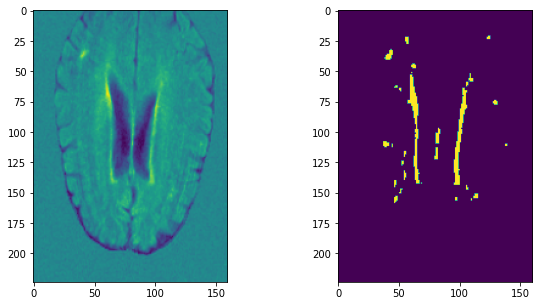

In [14]:
# plot an image
#img, label = train_dataset[10]
img, label = datasets_domains[6][121]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img.numpy()[0,:,:])
plt.subplot(1,2,2)
plt.imshow((label.numpy()==1)[0,:,:])

### define model

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class SimpleBlock(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size, dropout_p, transpose_conv, 
                 max_pooling=False, dimensions=2):
        """
        dimensoins = 2 for 2D data, 3 for 3D data.
        """
        super().__init__()
        if dimensions == 2:
            if transpose_conv:
                self.conv = nn.ConvTranspose2d(in_filters, out_filters, kernel_size, stride=2, output_padding=1, padding=1)
            else:
                self.conv = nn.Conv2d(in_filters, out_filters, kernel_size, stride=1, padding=1)
            self.norm = nn.BatchNorm2d(out_filters)
            self.dropout = nn.Dropout2d(dropout_p)
            self.pool = F.max_pool2d
            
        elif dimensions == 3:
            if transpose_conv:
                self.conv = nn.ConvTranspose3d(in_filters, out_filters, kernel_size, stride=2, output_padding=1, padding=1)
            else:
                self.conv = nn.Conv3d(in_filters, out_filters, kernel_size, stride=1, padding=1)
            #self.norm = nn.InstanceNorm3d(out_filters)
            self.norm = nn.BatchNorm3d(out_filters)
            self.dropout = nn.Dropout3d(dropout_p)
            self.pool = F.max_pool3d
        else:
            raise ValueError("dimensions can be only 2 or 3 (for 2D or 3D) (int)")
        
        self.do_max_pool = max_pooling
        
    
    def forward(self, x):
        x = self.conv(x)
        if self.do_max_pool:
            x = self.pool(x, 2, 2)
        x = self.norm(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        return x  
    
    
def block_list(in_lists, out_lists, kernel_size=3, dropout_p=0.5, do_transpose_conv=False, max_pooling=True, dimensions=2):
    """
    return a module containing a list of blocks, (not connected in any way, but will be 
    properly recognised as model weights)
    """
    return nn.ModuleList([
        SimpleBlock(ins, outs, kernel_size, dropout_p, do_transpose_conv, max_pooling, dimensions)
        for (ins, outs) in
        zip(in_lists, out_lists)
    ])
    

class FullyConvolutionalAutoEncoder(nn.Module):
    def __init__(self, encoder_layers=[64, 128, 256, 512], decoder_layers=[512, 256, 128, 64], in_channels=3, out_channels=1, dimensions=2):
        super().__init__()
        
        self.encoder_blocks = block_list([in_channels] + encoder_layers[:-1], encoder_layers,
                                        3, 0.5, False, max_pooling=True, dimensions=dimensions)
        
        self.decoder_blocks = block_list([encoder_layers[-1]] + decoder_layers, decoder_layers + [out_channels],
                                        3, 0.5, True, max_pooling=False, dimensions=dimensions)
        
        self.soft = nn.Softmax(dim=1)
        
    def forward(self, x, encode=False):
        for enc_block in self.encoder_blocks:
            x = enc_block(x)
        
        if encode:
            return x
            
        for dec_block in self.decoder_blocks:
            x = dec_block(x)
            
        x = self.soft(x)
        return x
    
    
class TestKiUNet(nn.Module):
    # I have slightly adapted this to use transpose convolution layers as opposed to interpolation...
    # not sure if that is the best idea or not
    # the standard version (class below, uses interpolation like they do)
    def __init__(self, encoder_layers=[16,32,64], decoder_layers=[32,16,8], 
                 encoderf1_layers=[16,32,64], decoderf1_layers=[32,16,8], 
                 intere_layers=[16,32,64], interd_layers=[32,16],
                 in_channels=3, out_channels=1, kernel_size=3, dropout_p=0.5):
        super().__init__()
        self.kernel_size = kernel_size
        self.dropout_p = dropout_p
        dimensions=2
        
        
        self.encoder_blocks = block_list([in_channels] + encoder_layers[:-1], encoder_layers,
                                        kernel_size, dropout_p, False, max_pooling=True, dimensions=dimensions)
        
        self.decoder_blocks = block_list([encoder_layers[-1]] + decoder_layers[:-1], decoder_layers,
                                        kernel_size, dropout_p, False, max_pooling=False, dimensions=dimensions)
        
        self.encoderf1_blocks = block_list([in_channels] + encoderf1_layers[:-1], encoderf1_layers,
                                          kernel_size, dropout_p, False, max_pooling=False, dimensions=dimensions)
        
        self.decoderf1_blocks = block_list([encoderf1_layers[-1]] + decoderf1_layers[:-1], decoderf1_layers,
                                          kernel_size, dropout_p, False, max_pooling=True, dimensions=dimensions)
        
        self.intere1_blocks = block_list(intere_layers, encoder_layers, 
                                         kernel_size, dropout_p, False, max_pooling=False, dimensions=dimensions)
        
        self.intere2_blocks = block_list(encoder_layers, intere_layers, 
                                         kernel_size, dropout_p, False, max_pooling=False, dimensions=dimensions)
        
        self.interd1_blocks = block_list(interd_layers, decoder_layers, 
                                         kernel_size, dropout_p, False, max_pooling=False, dimensions=dimensions)
        
        self.interd2_blocks = block_list(decoder_layers, interd_layers,
                                        kernel_size, dropout_p, False, max_pooling=False, dimensions=dimensions)
        
        self.final_conv = nn.Conv2d(8, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
        self.soft = nn.Softmax(dim=1)
        
        self.mode = 'bilinear'
        self.upscale = lambda x : F.interpolate(x, scale_factor=2, mode=self.mode)
        
    def forward(self, x):
        
        unet_out = x
        kinet_out = x
        skip_conns_stack = []
        scale_factor = 1
        
        # encoder path
        num_blocks = len(self.encoder_blocks)
        for l in range(num_blocks):
            # standard forward pass for both paths
            unet_out = self.encoder_blocks[l](unet_out)
            kinet_out = self.upscale(self.encoderf1_blocks[l](kinet_out))
            
            tmp = unet_out
            
            # CRFB block
            scale_factor *= 4.
            crfb1 = self.intere1_blocks[l](kinet_out)
            unet_out = torch.add(
                unet_out,
                F.interpolate(crfb1, scale_factor=1./scale_factor, mode=self.mode)
            )
            
            crfb2 = self.intere2_blocks[l](tmp)
            kinet_out = torch.add(
                kinet_out,
                F.interpolate(crfb2, scale_factor=scale_factor,mode=self.mode)
            )
            
            # append skip connections
            if l != num_blocks - 1:
                skip_conns_stack.append((unet_out, kinet_out))
            
            
        # decoder path
        for l in range(len(self.decoder_blocks)):
            # standard forward pass for both paths
            unet_out = self.upscale(self.decoder_blocks[l](unet_out))
            kinet_out = self.decoderf1_blocks[l](kinet_out)
            
            tmp = unet_out
            
            # CRFB block
            if l != num_blocks - 1:
                scale_factor /= 4.
                crfb1 = self.interd1_blocks[l](kinet_out)
                unet_out = torch.add(
                    unet_out,
                    F.interpolate(crfb1, scale_factor=1./scale_factor, mode=self.mode)
                )

                crfb2 =self.interd2_blocks[l](tmp)
                kinet_out = torch.add(
                    kinet_out,
                    F.interpolate(crfb2, scale_factor=scale_factor, mode=self.mode)
                )
            
            # add skip connections
            if l != num_blocks - 1:
                unet_skipc, kinet_skipc = skip_conns_stack.pop() # pop implements LIFO stack behaviour
                unet_out = torch.add(unet_out, unet_skipc)
                kinet_out = torch.add(kinet_out, kinet_skipc)
            
        
        # fusion of both branches
        out = torch.add(unet_out, kinet_out)
        out = self.final_conv(out)
        out = self.soft(out)
        
        return out

In [16]:
# model = TestKiUNet(encoder_layers=[16,32,64], 
#                  decoder_layers=[32,16,8], 
#                  encoderf1_layers=[16,16,16], 
#                  decoderf1_layers=[16,16,8], 
#                  intere_layers=[16,16,16],
#                  interd_layers=[32,16],
#                  in_channels=2,
#                  out_channels=1,
#                  kernel_size=3,
#                  dropout_p=0.1)
# model = UNet(encoder_channels=(2,64,128,256,512,1024),
#                 decoder_channels=(1024,512,256,128,64),
#                 dropout_p=0.1,
#                 num_classes=1,
#                 retain_dim=False,
#                 output_size=(224,160)
#             )
model = TUNet(in_channels=2, out_channels=1, init_features=32, dropout_p=0.)
model_uncert = TUNet(in_channels=2, out_channels=1, init_features=32, dropout_p=0., sigmoid=False)

In [17]:
#summary(model, (16, 2, 224, 160))

### define fitter

In [18]:
#loss = TverskyLoss()
loss = DiceLoss()
logging_metrics = [("dice",dice), ("IOU",IOU)]
fitter = StandardLitModelWrapper(model,
                                 train_dataloader,
                                 test_dataloader,
                                 val_dataloader,
                                 None,
                                 loss,
                                 logging_metrics
                                )

In [19]:
fitter_uncert = StandardLitModelWrapper(model_uncert,
                                 train_dataloader,
                                 test_dataloader,
                                 val_dataloader,
                                 None,
                                 loss,
                                 logging_metrics
                                )

In [20]:
#checkpoint_dir = "/media/benp/NVMEspare/model_data/trustworthai/initial_tests"
checkpoint_dir = "/disk/scratch/s2208943/results/"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

precision = None
precision = 16
trainer = get_trainer(checkpoint_dir, accelerator="gpu", devices=1, max_epochs=400,
                      strategy=strategy, precision=precision
                     )

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


**train for 5 epochs**


In [21]:
# trainer.fit(fitter, train_dataloader, val_dataloader)

/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /disk/scratch_fast/s2208943/results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type     | Params
-----------------------------------
0 | model | UNet     | 7.8 M 
1 | loss  | DiceLoss | 0     
-----------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
15.526    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.352


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 0.293


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.291


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.289


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### loading a saved checkpoint

In [21]:
saved_dir = "/disk/scratch/s2208943/best_models/"
ckpt = saved_dir + "batchnorm_only_epoch3.ckpt"

checkpoint = torch.load(ckpt)
fitter.load_state_dict(checkpoint['state_dict'])
fitter_uncert.load_state_dict(checkpoint['state_dict'])
checkpoint['epoch']

3

In [22]:
# result = trainer.predict(model=fitter, dataloaders = val_dataloader, ckpt_path=ckpt)

In [22]:
testresult = trainer.test(model=fitter, dataloaders = test_dataloader, ckpt_path=ckpt)

Restoring states from the checkpoint path at /disk/scratch/s2208943/best_models/batchnorm_only_epoch3.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkpoint at /disk/scratch/s2208943/best_models/batchnorm_only_epoch3.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3185354471206665
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [23]:
testresult = trainer.test(model=fitter_uncert, dataloaders = test_dataloader, ckpt_path=ckpt)

Restoring states from the checkpoint path at /disk/scratch/s2208943/best_models/batchnorm_only_epoch3.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkpoint at /disk/scratch/s2208943/best_models/batchnorm_only_epoch3.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0280632972717285
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [24]:
# batch = next(iter(val_dataloader))

In [26]:
# with torch.no_grad():
#     model.eval()
#     imgs, labels = batch
#     result = model(imgs.cuda()).cpu()

In [27]:
# result.shape

torch.Size([16, 1, 224, 160])

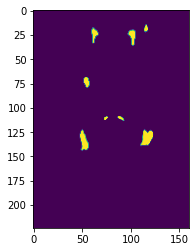

In [29]:
# plt.imshow(result[3].squeeze())

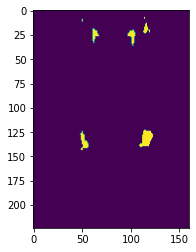

In [30]:
# plt.imshow(labels[3].squeeze())

In [28]:
1 - loss(result, labels)

tensor(0.7456)

### Loop of the test data
loop a few times see how consistent the result is

In [24]:
testresult = trainer.test(model=fitter, dataloaders = test_dataloader, ckpt_path=ckpt)

Restoring states from the checkpoint path at /disk/scratch/s2208943/best_models/batchnorm_only_epoch3.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkpoint at /disk/scratch/s2208943/best_models/batchnorm_only_epoch3.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3220585882663727
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [25]:
# collect a round of the test dataloader
def collect_test_data():
    batches = []
    for batch in test_dataloader:
        batches.append(batch)
    return batches

In [26]:
test_batches = collect_test_data()

In [27]:
from tqdm import tqdm

###  Produce Uncertainty maps

In [28]:
def batch_norm_uncertainty(model_pred, model_uncert, train_dataloader, test_batches, runs=3):
    # model_pred=model_pred.cuda()
    model_uncert = model_uncert.cuda()
    data_iter = iter(train_dataloader)
    results_per_run = []
    
    for run in range(runs):
        with torch.no_grad():
            print("run: ", run)
            # update BN parameters
            model_uncert.train()
            X, y = next(data_iter)
            _ = model_uncert(X.cuda())
            
            # now predict on the target data
            print("iterating test data")
            model_uncert.eval()
            test_results = []
            for tb in tqdm(test_batches, position=0, leave=True):
                Xt, yt = tb
                yt_hat = model_uncert(Xt.cuda()).cpu()
                test_results.append(yt_hat)
            
            results_per_run.append(test_results)
            # test_results = trainer.predict(model=fitter, dataloaders = test_batches, ckpt_path=ckpt)
            # results_per_run.append(test_results)
            
    return results_per_run


In [93]:
results_per_run = batch_norm_uncertainty(None, fitter_uncert, train_dataloader, test_batches, runs=64)

run:  0
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 41.74it/s]


run:  1
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:01<00:00, 43.08it/s]


run:  2
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 42.31it/s]


run:  3
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 32.70it/s]


run:  4
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:04<00:00, 20.97it/s]


run:  5
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 26.25it/s]


run:  6
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 42.19it/s]


run:  7
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 41.81it/s]


run:  8
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:04<00:00, 18.94it/s]


run:  9
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 42.82it/s]


run:  10
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 41.68it/s]


run:  11
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 42.02it/s]


run:  12
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 40.97it/s]


run:  13
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 35.61it/s]


run:  14
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 35.25it/s]


run:  15
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 37.64it/s]


run:  16
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 33.22it/s]


run:  17
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 37.10it/s]


run:  18
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 41.51it/s]


run:  19
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 41.93it/s]


run:  20
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 39.91it/s]


run:  21
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 39.25it/s]


run:  22
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 26.12it/s]


run:  23
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 38.99it/s]


run:  24
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 38.69it/s]


run:  25
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 42.05it/s]


run:  26
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 41.87it/s]


run:  27
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 30.37it/s]


run:  28
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 32.42it/s]


run:  29
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 39.08it/s]


run:  30
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 27.89it/s]


run:  31
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 39.55it/s]


run:  32
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 41.21it/s]


run:  33
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 28.67it/s]


run:  34
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 33.67it/s]


run:  35
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 28.57it/s]


run:  36
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 36.16it/s]


run:  37
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 34.60it/s]


run:  38
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 35.02it/s]


run:  39
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 36.71it/s]


run:  40
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 34.06it/s]


run:  41
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 37.23it/s]


run:  42
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 27.14it/s]


run:  43
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 36.35it/s]


run:  44
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 26.63it/s]


run:  45
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 36.69it/s]


run:  46
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 24.99it/s]


run:  47
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 35.25it/s]


run:  48
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 24.94it/s]


run:  49
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 35.47it/s]


run:  50
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 22.97it/s]


run:  51
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 35.04it/s]


run:  52
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 22.88it/s]


run:  53
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 35.84it/s]


run:  54
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 24.20it/s]


run:  55
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 36.69it/s]


run:  56
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 34.63it/s]


run:  57
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 24.57it/s]


run:  58
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 35.70it/s]


run:  59
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 27.33it/s]


run:  60
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 35.68it/s]


run:  61
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 25.06it/s]


run:  62
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 35.50it/s]


run:  63
iterating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 27.58it/s]


In [94]:
from collections import defaultdict

In [95]:
def get_uncertainty_map(results_per_run):
    # rearrange into batch, run arrays
    batches = len(results_per_run[0])
    results_per_batch = defaultdict(lambda : [])
    for run, rdata in enumerate(results_per_run):
        for batch, bdata in enumerate(rdata):
            results_per_batch[batch].append(bdata)
    # 
    variances_per_batch = []
    for batch in range(batches):
        samples = torch.permute(torch.stack(results_per_batch[batch]), (1,0,2,3,4))
        samples = torch.var(samples, dim=1)
        variances_per_batch.append(samples)
        
    return variances_per_batch

In [96]:
sample_variance = get_uncertainty_map(results_per_run)

In [97]:
len(sample_variance)

86

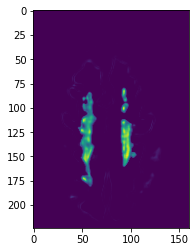

In [98]:
plt.imshow(sample_variance[0][6][0,:,:].numpy())

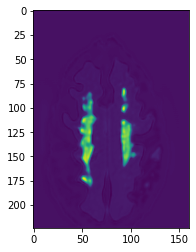

In [99]:
plt.imshow(results_per_run[4][0][6][0,:,:].numpy())

In [100]:
def get_predictions(results_per_run):
    run0 = results_per_run[0]
    predictions = []
    for batch in run0:
        predictions.append(torch.sigmoid(batch))
    return predictions
        

In [101]:
predictions = get_predictions(results_per_run)

In [102]:
len(predictions)

86

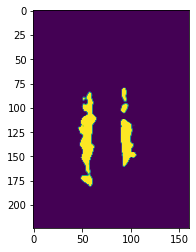

In [103]:
# prediction
plt.imshow(predictions[0][6].numpy()[0,:,:])  # run, batch, img

### Produce Calibration plots

In [104]:
len(test_batches[0])

2

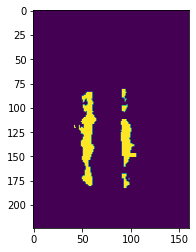

In [105]:
# actual map
plt.imshow(test_batches[0][1][6].numpy()[0,:,:])

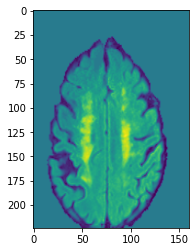

In [106]:
# flair
plt.imshow(test_batches[0][0][6].numpy()[0,:,:])

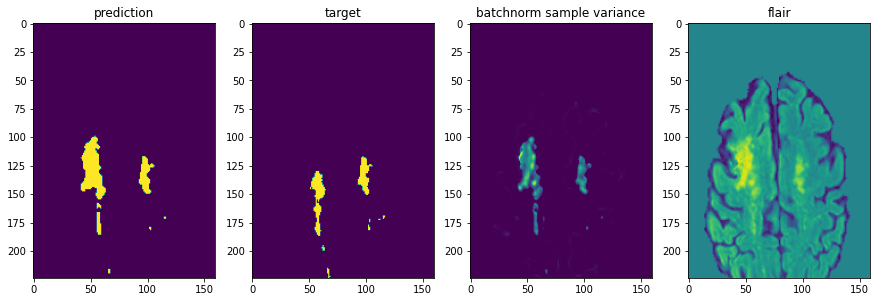

In [181]:
batch_idx = 4
img_imdx = 1

prediction = predictions[batch_idx][img_imdx].numpy()[0,:,:]
uncertainty_map = sample_variance[batch_idx][img_imdx][0,:,:].numpy()
target = test_batches[batch_idx][1][img_imdx].numpy()[0,:,:]
flair = test_batches[batch_idx][0][img_imdx].numpy()[0,:,:]

plt.figure(figsize=(15,10))
plt.subplot(1,4,1)
plt.imshow(prediction)
plt.title("prediction")
plt.subplot(1,4,2)
plt.imshow(target)
plt.title("target")
plt.subplot(1,4,3)
plt.imshow(uncertainty_map)
plt.title("batchnorm sample variance")
plt.subplot(1,4,4)
plt.imshow(flair)
plt.title("flair")
plt.show()

### Dice vs Uncertainty Plot

In [165]:
def dice_dim(y_pred, y_true, dim):
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred<=0.5] = 0
    y_true[y_true > 0.5] = 1
    y_true[y_true<=0.5] = 0
    denominator = torch.sum(y_pred, dim=dim) + torch.sum(y_true, dim=dim)
    numerator = 2. * torch.sum(torch.logical_and(y_pred, y_true), dim=dim)
    return numerator / (denominator +1e-8)
    

In [166]:
bce = BCELoss(reduction=None)

In [167]:
ind_dices = []
total_us = []
mean_us = []
for batch, batch_data in enumerate(predictions):
    target_batch = test_batches[batch][1]
    dices = dice_dim(batch_data, target_batch, dim=[1,2,3])
    #dices = bce(batch_data, target_batch)
    total_uncertainty = torch.sum(sample_variance[batch], dim=[1,2,3])
    mean_uncertainty = torch.mean(sample_variance[batch], dim=[1,2,3])
    
    ind_dices.append(dices)
    total_us.append(total_uncertainty)
    mean_us.append(mean_uncertainty)
    
    

In [168]:
len(ind_dices)

86

In [169]:
ds, tus, mus = torch.cat(ind_dices).numpy(), torch.cat(total_us).numpy(), torch.cat(mean_us).numpy()

In [170]:
len(ds)

1369

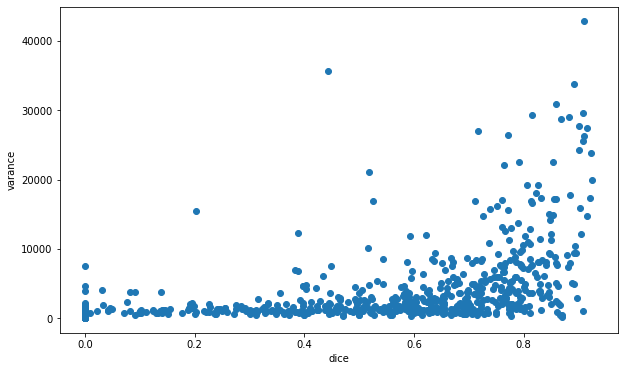

In [187]:
plt.figure(figsize=(10,6))
plt.scatter(ds, tus)
plt.xlabel("dice")
plt.ylabel("varance")
plt.show()

array([0.        , 0.59836066, 0.6902655 , ..., 0.        , 0.        ,
       0.7061878 ], dtype=float32)